In [1]:
from sqlalchemy import create_engine
from operator import itemgetter
import json
import math

import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
engine = create_engine('sqlite:///tab.db')
conn = engine.connect()

dfo = pd.read_sql_table('race', conn)
print('{} races loaded!'.format(len(dfo)))

9299 races loaded!


In [3]:
category = 'G'
dfo = dfo.loc[dfo['race_type'].isin([category])]
print('{} {} races!'.format(len(dfo), category))

3796 G races!


In [4]:
dfo['results'] = dfo['results_data'].map(json.loads)
dfo['runners'] = dfo['runners_data'].map(json.loads)
dfo.describe()

,id,race_number,race_distance,num_runners
count,3796.000000,3796.000000,3796.000000,3796.000000
mean,5195.928082,6.391992,435.177028,7.641201
std,2899.775745,3.288368,82.814514,0.777367
min,1.000000,1.000000,0.000000,4.000000
25%,3011.750000,4.000000,390.000000,8.000000
50%,5290.500000,6.000000,431.000000,8.000000
75%,7714.250000,9.000000,515.000000,8.000000
max,9971.000000,12.000000,732.000000,10.000000


In [5]:
# bet size
balance = 1000
bet_chunk = balance * 0.01

In [6]:
def bettable(r):
    return r['probability'] > r['odds_scale'] and r['odds_win'] > 0

In [7]:
def process_strategy(df, strategy):
    """run strategy, must pass runners returned back into results (it might be modified)"""
    book = []
    for _, race in df.iterrows():
#         print(race['num_runners'])
        runners = race['runners']
        
        # drop scratched
        runners = [r for r in runners if r['odds_win']]
        if not runners:
            continue
    
        # default 0 bets
        for runner in runners:
            runner['bet'] = 0
        
        runners, num_bets = strategy(runners, bet_chunk)
        if num_bets:
            bet_results(book, runners, race['num_runners'], bet_chunk, num_bets, race['race_type'])
    return book

In [8]:
def bet_results(book, runners, num_runners, bet_chunk, num_bets, race_type):
    """get results from bets"""
    win_diff = 0
    max_diff = 0
    outcome = {
        'success': 0,
        'profit': -bet_chunk,
        'num_bets': num_bets,
        'num_runners': num_runners,
    }
    for i, runner in enumerate(runners):
        diff = abs(runner['odds_scale'] - runner['probability'])
        max_diff = max(max_diff, diff)
        if int(runner['finishingPosition']) == 1:
            win_diff = diff
            if runner['bet'] > 0:
                # odds = runner['parimutuel']['returnWin'] if runner['parimutuel']['returnWin'] else runner['odds_win']
                odds = runner['odds_win']
                profit = runner['bet'] * odds - bet_chunk
                outcome = {
                    'success': 1,
                    'profit': profit,
                    'num_bets': num_bets,
                    'num_runners': num_runners,
                }
            break

    outcome['max_diff'] = max_diff
    outcome['win_diff'] = win_diff
    outcome['bet_chunk'] = bet_chunk
    outcome['race_type'] = race_type
    outcome['runners'] = runners
    book.append(outcome)

In [ ]:
def bet_positive_max(runners, bet_chunk):
    """bet max given prob>scale"""

    diffs = [(r['probability'] - r['odds_scale'], r) for r in runners]
    diffs.sort(key=itemgetter(0), reverse=True)

    ##############################################################################################
    # -1% roi 42% wr 100% races
    ##############################################################################################
#     num_bets = math.ceil(len(runners) * 0.125)


    ##############################################################################################
    # -2% roi 29% wr 100% races
    ##############################################################################################
    num_bets = 1


    ##############################################################################################
    # 10% roi 35% wr 33% races
    ##############################################################################################
#     num_bets = 1
#     if len(runners) > 8:
#         return [], 0

    
    ##############################################################################################
    # -3% roi 31% wr 77% races
    ##############################################################################################
#     num_bets = 1
#     if len(runners) > 12:
#         return [], 0

    
    ##############################################################################################
    # 0% roi 53% wr 33% races
    ##############################################################################################
#     num_bets = 2
#     if len(runners) > 8:
#         return [], 0

    total_probs = sum(d[1]['probability'] for d in diffs[:num_bets])
    for d, r in diffs[:num_bets]:
        r['bet'] = bet_chunk * r['probability'] / total_probs

    runners = [d[1] for d in diffs]
    return runners, num_bets


dfo = dfo.sample(frac=1).reset_index(drop=True)
print('Dataframe shuffled!')

book = process_strategy(dfo, bet_positive_max)

In [158]:
def bet_positive_dutch(runners, bet_chunk):
    """dutch betting on probability"""

    # sort runners from favourite to underdog
    ###############################################################################################
    # -10% roi 69% wr 100% races
    # runners.sort(key=itemgetter('probability'), reverse=True)
    ###############################################################################################
    # -7% roi 68% wr 100% races
    runners.sort(key=lambda r: r['probability'] - r['odds_scale'], reverse=True)
    ###############################################################################################
    
    # start betting on all and cut off worse runner till positive outcome
    for num_bets in range(len(runners), 0, -1):

        # reset bets for every iteration
        for runner in runners:
            runner['bet'] = 0

        # recreate smaller pool
        pool = runners[:num_bets]
        # print('pool is {} from {} bets'.format(len(pool), num_bets))

        # all odds
        total_probs = sum([r['probability'] for r in pool])
#         total_scale = sum([r['odds_scale'] for r in pool])
        # print('total probability = {}'.format(total))

        # dutch for all in pool
        profits = []
        for runner in pool:

            # scale bet according to odds or prediction?
            ###################################################################################
            # -7% roi 68% wr
            runner['bet'] = bet_chunk * runner['probability'] / total_probs
            ###################################################################################
            # -13% roi 79% wr 100% races
            # runner['bet'] = bet_chunk * runner['odds_scale'] / total_scale
            ###################################################################################
            
            # need to check all as we scale to probs and not odds
            profits.append(runner['bet'] * runner['odds_win'] - bet_chunk)
            
#         if num_bets >= 4:
#             continue
            
        if min(profits) <= 0:
            continue

        # exit with average profit
        avg_profit = sum(profits) / len(profits)
        
        ###################################################################################
        # -13.5% 78%w 38/38
        #if avg_profit > 0:
        ###################################################################################
        # -0.4  25  12/38
        if avg_profit > bet_chunk * 2:
        ###################################################################################
        # 2.2  23  9/38
        #if avg_profit > bet_chunk * 2.2:
        ###################################################################################
        # 10.4  22  6/38
        #if avg_profit > bet_chunk * 2.5:
        ###################################################################################
        # 28.1  20  2/38
        #if avg_profit > bet_chunk * 3:
            break
            
        if num_bets == 2:
            break
    else:
        #print('no profit determined')
        return [], 0

    # put bets from pool into runners
    for p in pool:
        for r in runners:
            if r['runnerNumber'] == p['runnerNumber']:
                r['bet'] = p['bet']
                break

    return runners, num_bets


dfo = dfo.sample(frac=1).reset_index(drop=True)
print('Dataframe shuffled!')

book = process_strategy(dfo, bet_positive_dutch)

Dataframe shuffled!


In [159]:
df = pd.DataFrame(book)
df.tail(10)

,bet_chunk,max_diff,num_bets,num_runners,profit,race_type,runners,success,win_diff
3717,10.0,0.037130,2,8.0,-10.000000,G,"[{'runnerName': 'SHE'S DEE ROCKET', 'runnerNum...",0,0.011348
3718,10.0,0.038548,2,7.0,2.990436,G,"[{'runnerName': 'INTER OBLIVION', 'runnerNumbe...",1,0.038548
3719,10.0,0.033763,2,8.0,1.906883,G,"[{'runnerName': 'PETADALE', 'runnerNumber': 3,...",1,0.006541
3720,10.0,0.032277,2,6.0,-10.000000,G,"[{'runnerName': 'TOYSTORY WISHES', 'runnerNumb...",0,0.010026
3721,10.0,0.020043,2,8.0,-10.000000,G,"[{'runnerName': 'ON BILLY'S WINGS', 'runnerNum...",0,0.004173
3722,10.0,0.038524,2,7.0,-10.000000,G,"[{'runnerName': 'COSMIC BONUS', 'runnerNumber'...",0,0.000111
3723,10.0,0.042880,2,8.0,-10.000000,G,"[{'runnerName': 'DUTY FREE', 'runnerNumber': 2...",0,0.007941
3724,10.0,0.039083,2,8.0,2.676718,G,"[{'runnerName': 'CHROMOSOME FOUR', 'runnerNumb...",1,0.014709
3725,10.0,0.054042,2,8.0,3.971751,G,"[{'runnerName': 'HUGO LINX', 'runnerNumber': 6...",1,0.001217
3726,10.0,0.019732,2,8.0,-10.000000,G,"[{'runnerName': 'AZUMI CHIEF', 'runnerNumber':...",0,0.002624


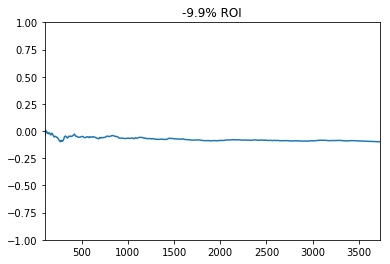

In [160]:
# ROI
roi = df.profit.cumsum() / df.bet_chunk.cumsum()
roi_title = '{:.1f}% ROI'.format(roi.iloc[-1] * 100)
roi.rolling(10).mean().plot(title=roi_title, xlim=(100), ylim=(-1, 1))

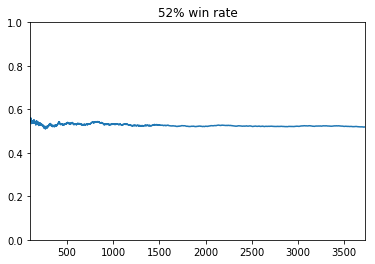

In [161]:
df['ones'] = np.ones(len(df))
df['win_rate'] = df.success.cumsum() / df.ones.cumsum()
win_title = '{:.0f}% win rate'.format(df.win_rate.iloc[-1] * 100)
df.win_rate.plot(title=win_title, xlim=(100), ylim=(0, 1))

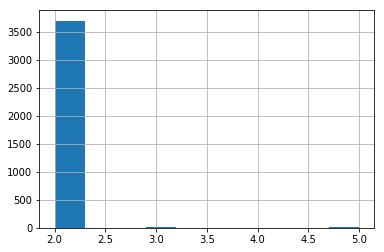

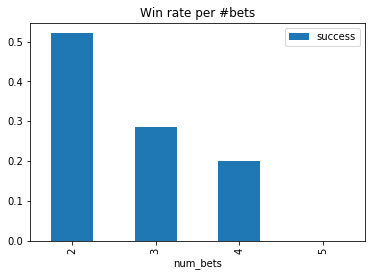

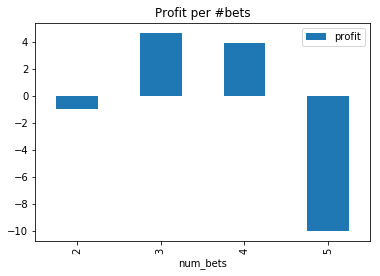

In [162]:
# profit per num bets 
df.num_bets.hist()
groups = df.groupby('num_bets').mean()
groups.plot(kind='bar', y='success', title='Win rate per #bets')
groups.plot(kind='bar', y='profit', title='Profit per #bets')

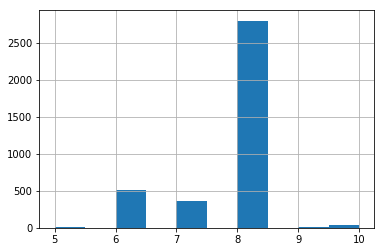

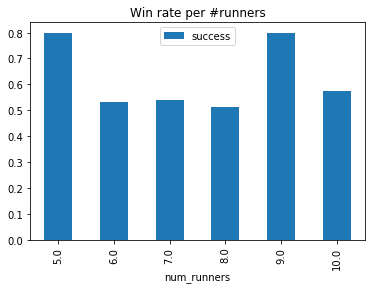

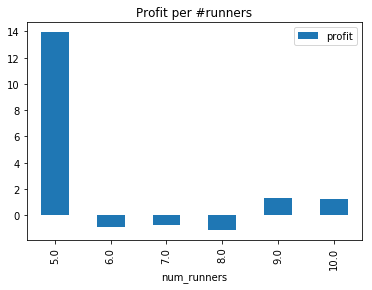

In [163]:
# profit per num runners
df.num_runners.hist()
groups = df.groupby('num_runners').mean()
groups.plot(kind='bar', y='success', title='Win rate per #runners')
groups.plot(kind='bar', y='profit', title='Profit per #runners')

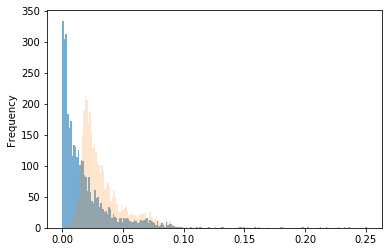

In [164]:
# max diff
df.win_diff.plot(kind='hist', bins=200, alpha=0.6)
df.max_diff.plot(kind='hist', bins=200, alpha=0.2)

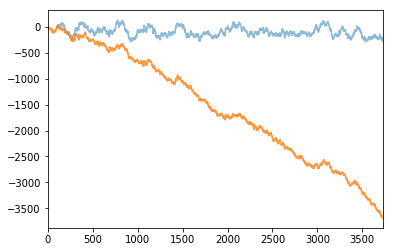

In [165]:
# df.profit.plot(kind='hist', bins=50, xlim=(-5), ylim=(0, 140))
df.profit.rolling(100).sum().plot(alpha=0.5)
df.profit.cumsum().plot(alpha=0.8)

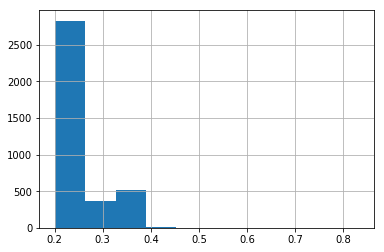

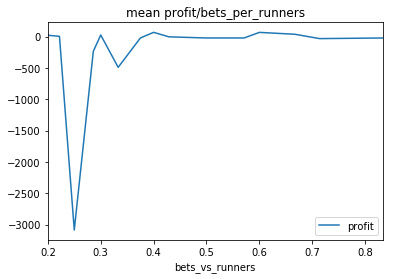

In [166]:
# bets/runners
df['bets_vs_runners'] = df.num_bets / df.num_runners
df['bets_vs_runners'].hist(bins=10)
groups = df.groupby(df['bets_vs_runners'].apply(lambda x: round(x, 3))).sum()
groups.plot(kind='line', y='profit', title='mean profit/bets_per_runners')